<a href="https://colab.research.google.com/github/aquapathos/Demo/blob/master/MNIST%E3%81%AE%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E5%AD%A6%E7%BF%92%E3%81%A8%E8%AD%98%E5%88%A5%E3%80%80CNN%E7%B7%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 2019/06/19現在，tensorflow-gpu と CUDAのバージョンがあってない模様
!pip install tensorflow-gpu --user

# CNN　畳み込みネットワーク

1. 入力層 (None,28,28,1) 
2. 畳み込み層 (5,5)のフィルタ × 32　→   (None,28,28,32)
3. プーリング層 (2,2)　→   (None,14,14,32)
4. 畳み込み層 (5,5)のフィルタ × 64　→   (None,14,14,64)
5. プーリング層 (2,2)　→   (None,7,7,64)
6. 平面化 (None, 7*7*64)
7. 全結合層 (None, 1024)
8. カテゴリ層 (None, 10)
9. Drop 50%
9. ソフトマックスで出力

畳み込み層ではランプ関数を特性関数とする


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import keras
import chainer

In [0]:
# データの確認
def plotchr(images,labels,categorical=False):
    sns.set_context("talk")   # "talk" はタイトルの文字サイズ。　paper <  notebook <  talk <  poster の順にフォントサイズが大きくなる
    low = (len(images)-1)//10+1
    for i,(image,label) in enumerate(zip(images,labels)):
        if categorical:
            label = np.argmax(label)
        image = image.reshape((28,28))
        plt.subplot(low,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title("%d" % label) # np.argmax は最大値のインデックスを求める関数．１はひとつしかないので，その位置がわかる．
        plt.imshow(image,cmap=plt.cm.gray_r)
        
# 識別結果の確認
def plotchr2(images,labels,clabels, categorical=False):
    sns.set_context("talk")   # "talk" はタイトルの文字サイズ。　paper <  notebook <  talk <  poster の順にフォントサイズが大きくなる
    low = (len(images)-1)//10+1
    for i,(image,label,clabel) in enumerate(zip(images,labels,clabels)):
        if categorical:
            label = np.argmax(label)
            clabel = np.argmax(clabel)
        image = image.reshape((28,28))
        plt.subplot(low,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title("{}/{}".format(label,clabel)) # np.argmax は最大値のインデックスを求める関数．１はひとつしかないので，その位置がわかる．
        plt.imshow(image,cmap=plt.cm.gray_r)


# TensorFlow

In [12]:
# tensorflow の場合のデータの読み込み方法
from tensorflow.examples.tutorials.mnist import input_data
mnistTF = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
#重み変数の定義マクロ
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
#バイアス変数の定義マクロ
def bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
#畳み込み演算のマクロ
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#MAXプーリングのマクロ
def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# モデルの作成
x = tf.placeholder(tf.float32, [None, 784]) # データの入れ物，placeholder [データ数, 784] という配列 
x_2d = tf.reshape(x, [-1,28,28,1]) # x を [データ数,縦,横,チャネル数]の形式に変換 
W_conv1 = weights([5, 5, 1, 32]) # 
b_conv1 = bias([32])
h_conv1 = tf.nn.relu(conv2d(x_2d, W_conv1) + b_conv1) # 畳み込み層１の出力
h_pool1 = max_pooling(h_conv1)
W_conv2 = weights([5, 5, 32, 64]) # 
b_conv2 = bias([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # 畳み込み層２の出力
h_pool2 = max_pooling(h_conv2)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) # 1次元化

W_w1 = weights([7*7*64, 1024]) 
b_w1 = bias([1024])
h_w1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_w1) + b_w1) #全結合層の出力

keep_prob = tf.placeholder(tf.float32) # dropしない率
h_w1d = tf.nn.dropout(h_w1, rate = 1- keep_prob)

W_w2 = weights([1024, 10])
b_w2 = bias([10])
i_w2 =  tf.matmul(h_w1d, W_w2) + b_w2

p = tf.nn.softmax(i_w2) # 内部状態が10個計算されてくるが，それをソフトマックスで１つにしぼる．

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# 誤差関数と最適化器の定義
t = tf.placeholder(tf.float32, [None,10])
loss = -tf.reduce_sum(t * tf.log(p))   
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(loss)

# 正解率の定義
correct_pred = tf.equal(tf.argmax(p,1),tf.argmax(t,1))   # 出力と正解が一致するかどうかの判定リスト　1 はどの次元を見るか．０はデータの次元なので１
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32)) # 真理値を浮動小数点化して平均をとる

In [14]:
# セッションの初期化

tf.set_random_seed(19601228)

sess = tf.InteractiveSession()
#sess = tf.Session()
sess.run(tf.global_variables_initializer())

/root/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# 学習の実行

In [15]:
BATCH_SIZE = 100

for i in range(2000):
    batch_tx, batch_tl = mnistTF.train.next_batch(BATCH_SIZE)
    train.run(feed_dict={x: batch_tx, t: batch_tl,keep_prob:0.5})
    # sess.run(train, feed_dict = {x: batch_tx, t: batch_tl,keep_prob:0.5})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
                                    feed_dict = {x:mnistTF.test.images, t: mnistTF.test.labels, keep_prob:1.0})
        print('Step:{0:5d}, Loss: {1:5.4f}, Accuracy: {2:5.4f}'.format(i, loss_val, acc_val))

Step:    0, Loss: 102808.0859, Accuracy: 0.1072
Step:  100, Loss: 1525.7164, Accuracy: 0.9548
Step:  200, Loss: 953.5440, Accuracy: 0.9706
Step:  300, Loss: 773.6329, Accuracy: 0.9761
Step:  400, Loss: 589.4596, Accuracy: 0.9800
Step:  500, Loss: 536.9294, Accuracy: 0.9810
Step:  600, Loss: 528.8530, Accuracy: 0.9836
Step:  700, Loss: 408.6290, Accuracy: 0.9860
Step:  800, Loss: 412.0117, Accuracy: 0.9857
Step:  900, Loss: 463.9847, Accuracy: 0.9843
Step: 1000, Loss: 431.9496, Accuracy: 0.9862
Step: 1100, Loss: 399.9485, Accuracy: 0.9867
Step: 1200, Loss: 344.9701, Accuracy: 0.9879
Step: 1300, Loss: 352.8664, Accuracy: 0.9878
Step: 1400, Loss: 341.7241, Accuracy: 0.9894
Step: 1500, Loss: 343.2440, Accuracy: 0.9886
Step: 1600, Loss: 311.0597, Accuracy: 0.9897
Step: 1700, Loss: 338.6680, Accuracy: 0.9891
Step: 1800, Loss: 360.1673, Accuracy: 0.9873
Step: 1900, Loss: 314.4142, Accuracy: 0.9896


# 識別テスト
９９％近い識別率が得られているので，めったに間違わない

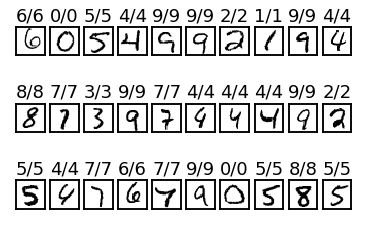

In [16]:
images, labels = mnistTF.test.images[100:130], mnistTF.test.labels[100:130]
predict = sess.run(p, feed_dict = {x: images, t: labels, keep_prob:1.0})
plotchr2(images,predict,labels,categorical=True)

# Keras 

In [0]:
# keras の場合のデータの読み込み方法
from keras.datasets import mnist
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()
# データ構造の変換
ytrain = keras.utils.to_categorical(ytrain, 10) # カテゴリカル表現に変換
ytest = keras.utils.to_categorical(ytest, 10)

Xtrain = Xtrain.reshape(-1,28,28,1)
Xtest = Xtest.reshape(-1,28,28,1)

Xtrain = Xtrain.astype('float32')   # int型をfloat32型に変換
Xtest = Xtest.astype('float32')
Xtrain /= 255                        # [0-255]の値を[0.0-1.0]に変換
Xtest /= 255

In [31]:
# モデルの構築
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers 

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),input_shape=(28,28,1), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              3212288   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
__________

In [33]:
BATCH_SIZE = 100
# 学習
history = model.fit(Xtrain, ytrain,  # 画像とラベルデータ
                    batch_size=BATCH_SIZE,
                    epochs=5,     # エポック数の指定
                    verbose=1,         # ログ出力の指定. 0だとログが出ない
                    validation_data=(Xtest, ytest))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.0438 - acc: 0.9864 - val_loss: 0.0289 - val_acc: 0.9900
Epoch 2/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.0328 - acc: 0.9899 - val_loss: 0.0234 - val_acc: 0.9915
Epoch 3/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.0237 - acc: 0.9926 - val_loss: 0.0280 - val_acc: 0.9901
Epoch 4/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.0193 - acc: 0.9941 - val_loss: 0.0259 - val_acc: 0.9913
Epoch 5/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0195 - val_acc: 0.9927


In [34]:
# 認識率評価
score = model.evaluate(Xtest, ytest, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01951733344426648
Test accuracy: 0.9927


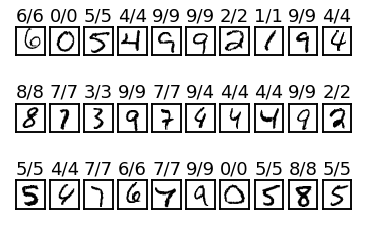

In [35]:
# 識別結果の確認
predict = model.predict(Xtest[100:130])
plotchr2(Xtest[100:130],predict,ytest[100:130],categorical=True)

# Chainer

In [36]:
import chainer.functions as F
import chainer.links as L
from chainer import training, Chain
import chainer.optimizers as optimizers
from chainer.datasets import split_dataset_random
from chainer.training import extensions

# chainer の場合のデータの読み込み方法
from chainer import datasets
trainC, testC = datasets.get_mnist(ndim=1)
imagesC = [image for (image,label) in trainC]
labelsC = [label for (image,label) in trainC]

# 訓練データを学習用と検証用に分割する．
trainC, validC = split_dataset_random(trainC, 55000, seed=0)
print(len(trainC),len(validC))

from chainer import iterators

batchsize = 100
epoch = 10
frequency = -1

# イテレータを作る

train_iter = iterators.SerialIterator(trainC, batchsize)
valid_iter = iterators.SerialIterator(
    validC, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    testC, batchsize, repeat=False, shuffle=False)

55000 5000


In [0]:
# GPU バージョン

from chainer import cuda

# モデル定義
class NNG(Chain):
    def __init__(self):
        super(NNG, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=32, ksize=5, stride=1, pad=2)
            self.conv2 = L.Convolution2D(
                in_channels=32, out_channels=64, ksize=5, stride=1, pad=2)
            self.fc4 = L.Linear(None, 1024)
            self.fc5 = L.Linear(1024, 10)

    def __call__(self, x):
        h = F.relu(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.softmax(self.fc4(h))
        return self.fc5(h)
    
# 学習
modelG = L.Classifier(NNG())

cuda.get_device(0).use()
modelG.to_gpu(0)

optimizerG = chainer.optimizers.Adam()
optimizerG.setup(modelG)

updaterG = training.StandardUpdater(train_iter, optimizerG, device=0)
trainerG = training.Trainer(updaterG, (epoch, 'epoch'))

trainerG.extend(extensions.Evaluator(test_iter, modelG,device=0))
trainerG.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainerG.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainerG.extend(extensions.LogReport())
trainerG.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='lossG.png'))
trainerG.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracyG.png'))
trainerG.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

In [46]:
trainerG.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.79755     1.38078               0.91323        0.973                     10.0083       
2           1.06764     0.793738              0.978673       0.9868                    14.1969       
3           0.622258    0.478002              0.985163       0.9854                    18.4996       
4           0.378364    0.301006              0.987963       0.9884                    23.0125       
5           0.243824    0.207597              0.991017       0.9888                    27.314        
6           0.167756    0.151261              0.992363       0.9897                    31.5839       
7           0.120304    0.116802              0.993744       0.9901                    35.8907       
8           0.0917209   0.0955188             0.993872       0.9901                    40.1589       
9           0.0687055   0.0767967             0.995254       0.9917                 

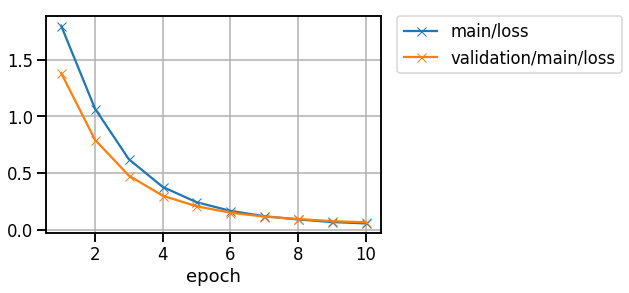

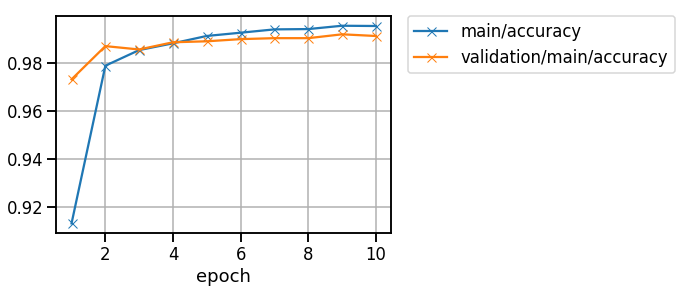

In [48]:
from IPython.display import Image, display_png
display_png(Image('result/lossG.png'))
display_png(Image('result/accuracyG.png'))

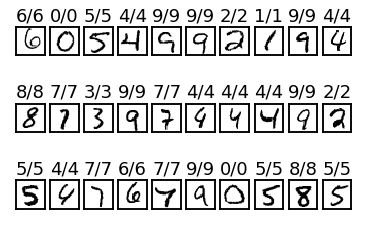

In [49]:
# 識別結果の確認（Chainer cuda版）
images = np.array([image for (image,label) in testC[100:130]])
imagesG = cuda.cupy.array(images)
labels = cuda.cupy.array([label for (image,label) in testC[100:130]])
predict = [cuda.cupy.argmax(x) for x in modelG.predictor(imagesG).data]
plotchr2(images,predict,labels,categorical=False)